<a href="https://colab.research.google.com/github/Quantyca/demo-ateam-ai-misc/blob/master/image-processing/peppers-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Peppers: train

## Set Env

Prepariamo l'ambiente colab installando fast.ai e le relative dipendenze ...

In [0]:
#!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
!pip list | grep fastai

fastai                   1.0.52               


In [0]:
! mkdir -p /root/.fastai/models
! mkdir -p /root/.fastai/data
! ln -s /root/.fastai/models /content
! ln -s /root/.fastai/data /content
! rm -rf /content/sample_data/
#! mkdir data models

In [0]:
!pwd && ls -l

/content
total 0
lrwxrwxrwx 1 root root 18 Jun  7 13:23 data -> /root/.fastai/data
lrwxrwxrwx 1 root root 20 Jun  7 13:23 models -> /root/.fastai/models


In [0]:
#TODO set random seed

## Import libs

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai import *
from fastai.vision import *
from fastai.utils.collect_env import *

In [0]:
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.52
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Jun  7 13:27:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+-------

## Getting the data

Il dataset è stato creato a mano utilizzando il tool [ai-utils](https://github.com/prairie-guy/ai_utilities). Le immagini sono state prese da google quindi ripulite a mano e poi salvate su google storage.

In [0]:
_=download_url('https://storage.googleapis.com/ml_quantyca_it/personal/andrea/spicyai/data/raw/peppersdataset.tar.gz','./peppersdataset.tar.gz',overwrite=True)

In [0]:
!ls .

data  models  peppersdataset.tar.gz


In [0]:
import tarfile
tarfile.open('peppersdataset.tar.gz', 'r:gz').extractall('.')

In [0]:
path = Path('./peppersdataset')

In [0]:
path.ls()

[PosixPath('peppersdataset/train'),
 PosixPath('peppersdataset/test'),
 PosixPath('peppersdataset/valid')]

## Looking at the data

In [0]:
data = ImageDataBunch.from_folder(path,ds_tfms=get_transforms(), size=224, bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1065 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Valid: LabelList (283 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Test: None

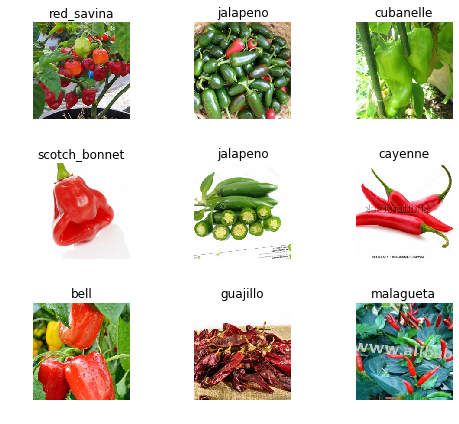

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['banana', 'bell', 'carolina_reaper', 'cayenne', 'cubanelle', 'guajillo', 'habanero', 'jalapeno', 'malagueta', 'naga_morich', 'pimento', 'red_savina', 'scotch_bonnet']


(13, 13)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 ouptuts).

We will train for 5 epochs (5 cycles through all our data).

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 41818589.49it/s]


Potemmo già addestrare il modello utilizzando il learning rate di default che è uguale a slice(None, 0.003, None) ma non lo faremo. @see [slice doc](https://docs.python.org/2.3/whatsnew/section-slices.html)

In [0]:
#learn.fit_one_cycle(5)

Cerchiamo infatti di trovare già al primo giro un learning rate ottimale per il nostro training set ...

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


One thing to notice here is that before we unfreeze you'll tend to get this shape pretty much all the time:

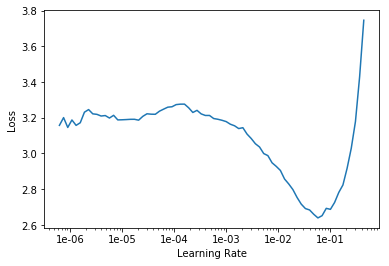

In [0]:
learn.recorder.plot()

It's pretty easy ﹣ find the steepest slope, not the bottom. Remember, we're trying to find the bit where we can like slide down it quickly. So if you start at the bottom it's just gonna send you straight off to the end here. In this case the thing with the steepest slope is  somewhere around 1e-2, make that our learning rate.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.853948,1.271428,0.399293,00:57
1,1.511749,1.183099,0.374558,00:57
2,1.259800,1.015957,0.303887,00:58
3,0.971153,0.891442,0.289753,00:59
4,0.732863,0.894315,0.282686,01:00


Fin che train loss è minore di valid loss siamo in underfitting. Si puo' quindi migliorare con altre epoche di addestramento. Si ha invece overfitting quando l'error rate dopo essere sceso riprende a salire

In [0]:
learn.model_dir = '/root/.fastai/models'

In [0]:
!ls {learn.model_dir}

In [0]:
learn.save('pep-stg1-rn34')

In [0]:
!ls -l /root/.fastai/models

total 89680
-rw-r--r-- 1 root root 91831810 Jun  7 13:58 pep-stg1-rn34.pth


In [0]:
#Uncomment the two lines below to download locally the saved model
#from google.colab import files
#files.download("/root/.fastai/models/pep-stg1-rn34.pth")

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

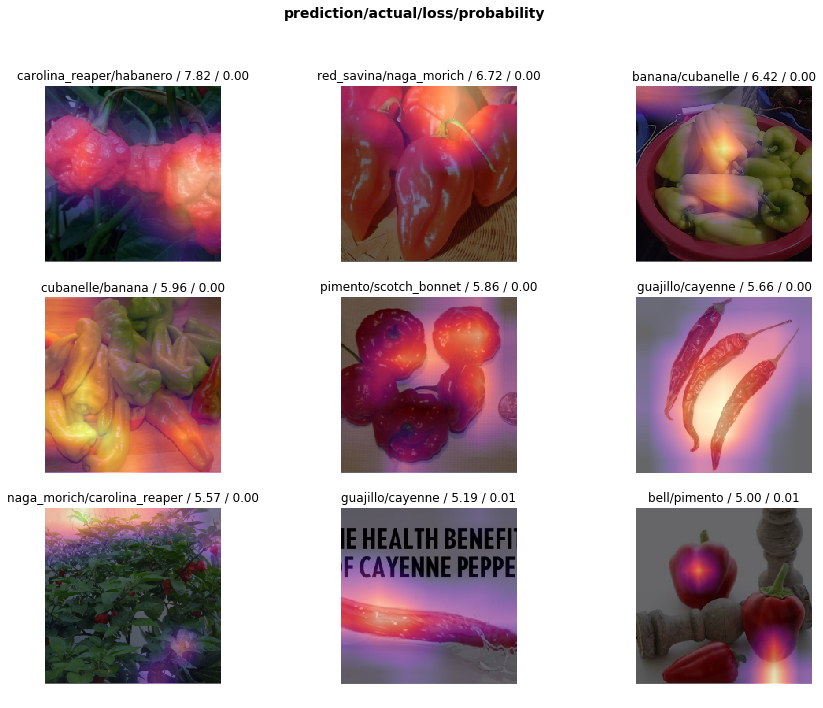

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

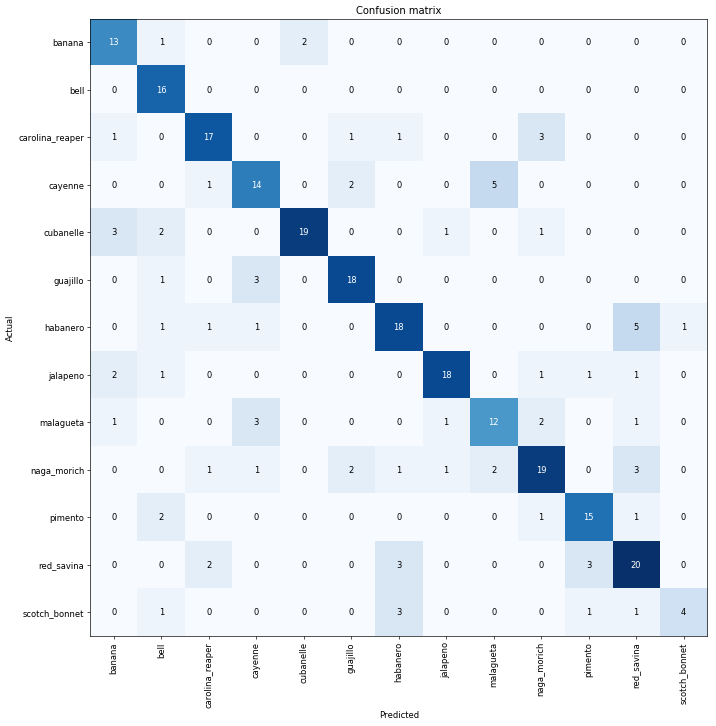

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('cayenne', 'malagueta', 5),
 ('habanero', 'red_savina', 5),
 ('carolina_reaper', 'naga_morich', 3),
 ('cubanelle', 'banana', 3),
 ('guajillo', 'cayenne', 3),
 ('malagueta', 'cayenne', 3),
 ('naga_morich', 'red_savina', 3),
 ('red_savina', 'habanero', 3),
 ('red_savina', 'pimento', 3),
 ('scotch_bonnet', 'habanero', 3),
 ('banana', 'cubanelle', 2),
 ('cayenne', 'guajillo', 2),
 ('cubanelle', 'bell', 2),
 ('jalapeno', 'banana', 2),
 ('malagueta', 'naga_morich', 2),
 ('naga_morich', 'guajillo', 2),
 ('naga_morich', 'malagueta', 2),
 ('pimento', 'bell', 2),
 ('red_savina', 'carolina_reaper', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Whne we re-calculate the learning rate again after unfreeze we generally get a very different shape.


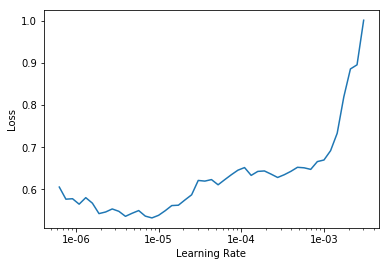

In [0]:
learn.recorder.plot()

This is a little bit harder to say what to look for because it tends to be this kind of shape where you get a little bit of upward and then it kind of very gradual downward and then up here. So I tend to kind of look for just before it shoots up and go back about 10x as a kind of a rule of thumb. So one 1e-5. That is what I do for the first half of my slice. And then for the second half of my slice, I normally do whatever learning rate are used for the the frozen part. So lr which was 0.01 kind of divided by five or ten. Somewhere around that. That's my rule of thumb:

* look for the bit kind of at the bottom find about 10x smaller that's the number that I put as the first half of my slice
*  lr/5 or lr/10 is kind of what I put as the second half of my slice

This is called discriminative learning rates as the course continues.

In [0]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,1.710157,8.312794,0.756184,01:00
1,2.096436,3.244088,0.731449,01:02
2,1.789116,1.887221,0.558304,01:02
3,1.512171,1.222856,0.406360,01:02
4,1.191789,1.027957,0.356890,01:02


In [0]:
#learn.load('stage-1')
#learn.unfreeze()
#learn.fit_one_cycle(5, slice(1e-4, lr/5))

Uno su 5 lo sbaglia. Non il massimo ma molte classi di peperoncini hanno differenze minime difficili da distinguere anche per un esperto.

In [0]:
learn.save('pep-stg2-rn34')

In [0]:
!ls -l /root/.fastai/models

total 430880
-rw-r--r-- 1 root root  91831810 Jun  7 13:58 pep-stg1-rn34.pth
-rw-r--r-- 1 root root 261984577 Jun  7 14:14 pep-stg2-rn34.pth
-rw-r--r-- 1 root root  87396915 Jun  7 14:03 tmp.pth


In [0]:
from google.colab import files
files.download("/root/.fastai/models/pep-stg2-rn34.pth")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 46654, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=400, bs=32)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1065 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Valid: LabelList (283 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Test: None

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 46681999.05it/s]


In [0]:
learn.fit_one_cycle(16)

epoch,train_loss,valid_loss,error_rate,time
0,2.343684,1.375129,0.409894,01:54
1,1.525239,0.878178,0.293286,01:38
2,1.126833,0.817037,0.265018,01:37
3,0.886830,0.817671,0.247350,01:37
4,0.735293,0.745099,0.233216,01:37
5,0.617494,0.730986,0.212014,01:36
6,0.509662,0.696084,0.208481,01:36
7,0.423864,0.703290,0.201413,01:39
8,0.364411,0.743928,0.219081,01:37
9,0.307625,0.721599,0.190813,01:37


In [0]:
learn.model_dir = '/root/.fastai/models'

In [0]:
learn.save('pep-stg1-rn50')

In [0]:
!ls -l /root/.fastai/models

total 548224
-rw-r--r-- 1 root root  91831810 Jun  7 13:58 pep-stg1-rn34.pth
-rw-r--r-- 1 root root 120158291 Jun  7 15:06 pep-stg1-rn50.pth
-rw-r--r-- 1 root root 261984577 Jun  7 14:14 pep-stg2-rn34.pth
-rw-r--r-- 1 root root  87396915 Jun  7 14:03 tmp.pth


In [0]:
learn.load('pep-stg1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (1065 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Valid: LabelList (283 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1)

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.197388,0.730215,0.194346,01:37


Non abbiamo migliorato, possiamo fermarci.

In [0]:
learn.load('pep-stg1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (1065 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Valid: LabelList (283 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet,scotch_bonnet
Path: peppersdataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

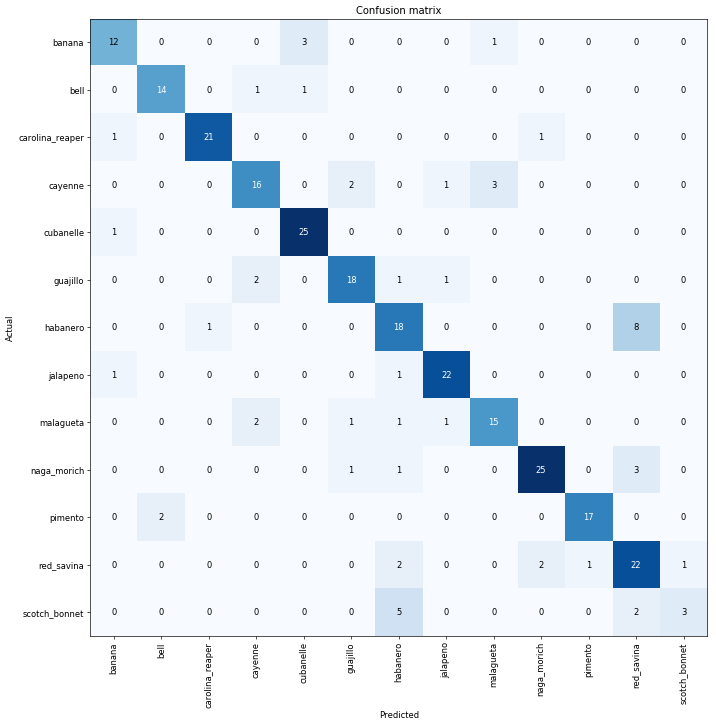

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=1)

[('habanero', 'red_savina', 8),
 ('scotch_bonnet', 'habanero', 5),
 ('banana', 'cubanelle', 3),
 ('cayenne', 'malagueta', 3),
 ('naga_morich', 'red_savina', 3),
 ('cayenne', 'guajillo', 2),
 ('guajillo', 'cayenne', 2),
 ('malagueta', 'cayenne', 2),
 ('pimento', 'bell', 2),
 ('red_savina', 'habanero', 2),
 ('red_savina', 'naga_morich', 2),
 ('scotch_bonnet', 'red_savina', 2),
 ('banana', 'malagueta', 1),
 ('bell', 'cayenne', 1),
 ('bell', 'cubanelle', 1),
 ('carolina_reaper', 'banana', 1),
 ('carolina_reaper', 'naga_morich', 1),
 ('cayenne', 'jalapeno', 1),
 ('cubanelle', 'banana', 1),
 ('guajillo', 'habanero', 1),
 ('guajillo', 'jalapeno', 1),
 ('habanero', 'carolina_reaper', 1),
 ('jalapeno', 'banana', 1),
 ('jalapeno', 'habanero', 1),
 ('malagueta', 'guajillo', 1),
 ('malagueta', 'habanero', 1),
 ('malagueta', 'jalapeno', 1),
 ('naga_morich', 'guajillo', 1),
 ('naga_morich', 'habanero', 1),
 ('red_savina', 'pimento', 1),
 ('red_savina', 'scotch_bonnet', 1)]

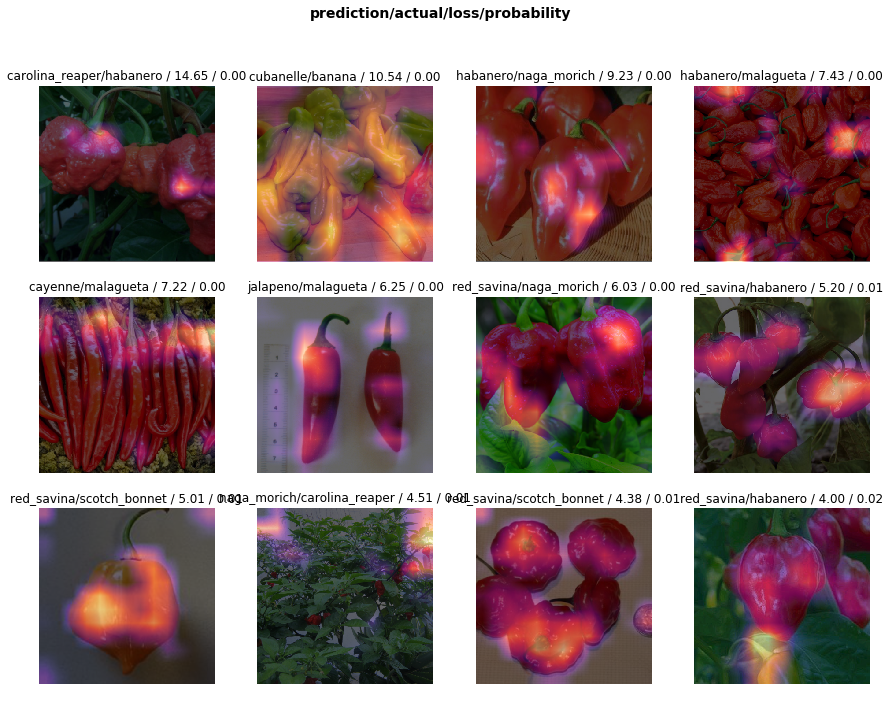

In [0]:
interp.plot_top_losses(12, figsize=(15,11))

## Save the model

To local disk:

In [0]:
!ls -l /root/.fastai/models

total 548224
-rw-r--r-- 1 root root  91831810 Jun  7 13:58 pep-stg1-rn34.pth
-rw-r--r-- 1 root root 120158291 Jun  7 15:06 pep-stg1-rn50.pth
-rw-r--r-- 1 root root 261984577 Jun  7 14:14 pep-stg2-rn34.pth
-rw-r--r-- 1 root root  87396915 Jun  7 14:03 tmp.pth


In [0]:
from google.colab import files
files.download("/root/.fastai/models/pep-stg1-rn50.pth")

To drive:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /root/.fastai/models/pep-stg1-rn50.pth /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/pep-stg1-rn50.pth
#copyfile('/root/.torch/models/pep-stg1-rn50.pth', 'gdrive/My Drive/Quantyca/Quantyca - Colab Notebooks/fast.ai DLp1v3/pep-stg1-rn50.pth')
#copyfile('/root/.torch/models/pep-stg1-rn50.pth', 'gdrive/My Drive/pep-stg1-rn50.pth')

To google storage:

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# First, we need to set our project. Replace the assignment below
# with your project ID.
project_id = 'quantyca-ml'

In [0]:
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [0]:
!gsutil cp /root/.fastai/models/pep-stg1-rn50.pth gs://ml_quantyca_it/personal/andrea/spicyai/models

Copying file:///root/.fastai/models/pep-stg1-rn50.pth [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/114.6 MiB.                                    


In [0]:
# END